# Set-up

## Imports

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import seaborn as sns
import plotly.express as px
import mpltern
from matplotlib.cm import plasma, twilight_shifted, cool
from utils import month_to_season
sns.set_theme()

colors = sns.color_palette("deep")

## Functions

In [2]:
def plot_components(H, ax=None, figsize=(10, 6), **kwargs):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.get_figure()

    n_components = H.shape[0]
    abscissa = np.linspace(0, 24, H.shape[1])
    for k in range(n_components):
        label = f'Component {k + 1}'
        ax.plot(abscissa, H[k, :], linestyle='-', label=label, **kwargs)

    ax.set_xlabel('Hour')
    ax.set_ylabel('Normalized Load')
    # ax.set_title(title)
    ax.legend()
    
    return fig, ax

In [3]:
def plot_zone_concentrations(gdf, component, zone_names=True, ax=None, title=None, **kwargs):
    ax =  gdf.plot(component, ax=ax, **kwargs)
    ax.grid(False)
    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    # Remove axis labels
    ax.set_xlabel('')
    ax.set_ylabel('')

    if zone_names:
        # Add zone names
        for idx, row in gdf.iterrows():
            # Add halo effect on text
            ax.annotate(text=str(idx), xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                        xytext=(0, 0), textcoords="offset points", fontsize=9, color='white',
                        ha='center', va='center', zorder=5, fontweight='normal', path_effects=[path_effects.withStroke(linewidth=2, foreground='black')])
            # Add halo effect
            ax.annotate(text=idx, xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                        xytext=(0, 0), textcoords="offset points", fontsize=9, color='white',
                        ha='center', va='center', zorder=6, fontweight='normal')
            
    if title:
        ax.set_title(title)
        
    return ax

# Choropleth

## Read regions file

In [4]:
gdf = gpd.read_file('data/1_input/shapefiles/Limiti01012023_g/Reg01012023_g')
gdf

,COD_RIP,COD_REG,DEN_REG,Shape_Leng,Shape_Area,geometry
0,1,1,Piemonte,1.236800e+06,2.539388e+10,"POLYGON ((457749.464 5145501.795, 458662.395 5..."
1,1,2,Valle d'Aosta,3.109681e+05,3.258838e+09,"POLYGON ((390652.644 5091766.171, 390748.643 5..."
2,1,3,Lombardia,1.410223e+06,2.386232e+10,"MULTIPOLYGON (((485536.366 4985444.605, 485366..."
3,2,4,Trentino-Alto Adige,8.008937e+05,1.360755e+10,"POLYGON ((743267.749 5219765.793, 743387.812 5..."
4,2,5,Veneto,1.054587e+06,1.834355e+10,"POLYGON ((768123.960 5175397.497, 768135.210 5..."
5,2,6,Friuli Venezia Giulia,6.708207e+05,7.934116e+09,"MULTIPOLYGON (((872344.457 5061894.048, 872344..."
6,1,7,Liguria,8.196598e+05,5.414542e+09,"MULTIPOLYGON (((568226.691 4874823.573, 568219..."
7,2,8,Emilia-Romagna,1.180343e+06,2.249987e+10,"MULTIPOLYGON (((618343.929 4893985.661, 618335..."
8,3,9,Toscana,1.306243e+06,2.298404e+10,"MULTIPOLYGON (((674426.642 4680710.364, 674563..."
9,3,10,Umbria,6.197684e+05,8.464380e+09,"MULTIPOLYGON (((776982.140 4832209.918, 776910..."


<Axes: >

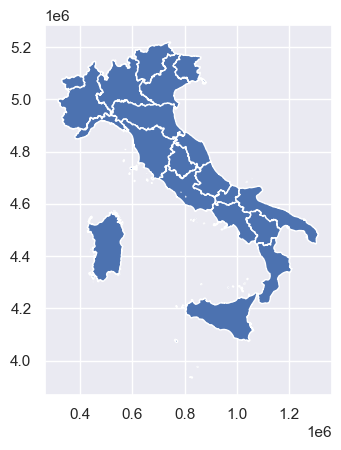

In [5]:
gdf.plot()

## Read Region-Zone mapping

In [6]:
# Read region zone mapping
region_zone_df = pd.read_excel('data/1_input/region_zone.xlsx', sheet_name='2021')
region_zone = dict(zip(region_zone_df['Region Istat'], region_zone_df['Zone']))
region_zone

{'Veneto': 'North',
 "Valle d'Aosta": 'North',
 'Umbria': 'Centre-South',
 'Trentino-Alto Adige': 'North',
 'Toscana': 'Centre-North',
 'Sicilia': 'Sicily',
 'Sardegna': 'Sardinia',
 'Puglia': 'South',
 'Piemonte': 'North',
 'Molise': 'South',
 'Marche': 'Centre-North',
 'Lombardia': 'North',
 'Liguria': 'North',
 'Lazio': 'Centre-South',
 'Friuli Venezia Giulia': 'North',
 'Emilia-Romagna': 'North',
 'Campania': 'Centre-South',
 'Calabria': 'Calabria',
 'Basilicata': 'South',
 'Abruzzo': 'Centre-South'}

## Create zone GeoDataFrame

In [7]:
gdf['zone'] = gdf.DEN_REG.map(region_zone)
gdf

,COD_RIP,COD_REG,DEN_REG,Shape_Leng,Shape_Area,geometry,zone
0,1,1,Piemonte,1.236800e+06,2.539388e+10,"POLYGON ((457749.464 5145501.795, 458662.395 5...",North
1,1,2,Valle d'Aosta,3.109681e+05,3.258838e+09,"POLYGON ((390652.644 5091766.171, 390748.643 5...",North
2,1,3,Lombardia,1.410223e+06,2.386232e+10,"MULTIPOLYGON (((485536.366 4985444.605, 485366...",North
3,2,4,Trentino-Alto Adige,8.008937e+05,1.360755e+10,"POLYGON ((743267.749 5219765.793, 743387.812 5...",North
4,2,5,Veneto,1.054587e+06,1.834355e+10,"POLYGON ((768123.960 5175397.497, 768135.210 5...",North
5,2,6,Friuli Venezia Giulia,6.708207e+05,7.934116e+09,"MULTIPOLYGON (((872344.457 5061894.048, 872344...",North
6,1,7,Liguria,8.196598e+05,5.414542e+09,"MULTIPOLYGON (((568226.691 4874823.573, 568219...",North
7,2,8,Emilia-Romagna,1.180343e+06,2.249987e+10,"MULTIPOLYGON (((618343.929 4893985.661, 618335...",North
8,3,9,Toscana,1.306243e+06,2.298404e+10,"MULTIPOLYGON (((674426.642 4680710.364, 674563...",Centre-North
9,3,10,Umbria,6.197684e+05,8.464380e+09,"MULTIPOLYGON (((776982.140 4832209.918, 776910...",Centre-South


In [8]:
gdf = gdf.dissolve('zone')
gdf

,geometry,COD_RIP,COD_REG,DEN_REG,Shape_Leng,Shape_Area
zone,,,,,,
Calabria,"MULTIPOLYGON (((1151641.891 4469099.212, 11516...",4,18,Calabria,8.378109e+05,1.521607e+10
Centre-North,"MULTIPOLYGON (((606596.711 4685835.347, 606590...",3,9,Toscana,1.306243e+06,2.298404e+10
Centre-South,"MULTIPOLYGON (((834081.926 4533605.514, 834106...",3,10,Umbria,6.197684e+05,8.464380e+09
North,"MULTIPOLYGON (((437898.212 4875140.946, 437941...",1,1,Piemonte,1.236800e+06,2.539388e+10
Sardinia,"MULTIPOLYGON (((449019.773 4301575.753, 449018...",5,20,Sardegna,1.438479e+06,2.409403e+10
Sicily,"MULTIPOLYGON (((800959.906 3939248.080, 800968...",5,19,Sicilia,1.337060e+06,2.582375e+10
South,"MULTIPOLYGON (((1073694.311 4445756.105, 10737...",4,14,Molise,4.338181e+05,4.461183e+09


## Load NMF data

In [9]:
# Load observations
specific = '_Italy'
infile = f'data/2_processed/daily_curves{specific}.csv'
curves_df = pd.read_csv(infile, index_col=0)
# HOTFIX for single-zone case
zone = 'Italy'
curves_df.index = zone + '_' + curves_df.index
unit_info = curves_df.index.str.extract(r'^(?P<zone>[\w.]+)_(?P<year>\d{4})-(?P<month>\d{2})-\d{2}_(?P<daytype>[\w ]+)$').set_index(curves_df.index)
curves_df = pd.concat([curves_df, unit_info], axis=1)
curves_df

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,zone,year,month,daytype
Italy_2018-01-01_Holiday,24743.000,23797.000,22175.999,21042.000,20146.999,20079.000,20942.001,21712.000,21969.999,22967.000,...,31537.000,30804.001,29621.000,27749.000,25388.000,22714.001,Italy,2018,01,Holiday
Italy_2018-01-02_Working day,22714.001,20794.001,19802.002,19573.002,19679.000,20891.000,24197.999,28537.000,32988.000,37794.999,...,42081.001,39555.000,37163.000,33313.000,29811.000,26314.001,Italy,2018,01,Working day
Italy_2018-01-03_Working day,26314.001,24248.999,22927.999,22537.999,22314.001,23529.001,27206.000,32970.999,37419.000,40908.999,...,43818.999,41347.000,38572.999,34229.001,30436.999,27199.000,Italy,2018,01,Working day
Italy_2018-01-04_Working day,27199.000,25051.000,23787.000,23393.000,23543.002,24245.999,27503.000,32829.000,37192.999,40642.001,...,43327.999,41224.999,38268.001,34536.000,31038.998,27480.999,Italy,2018,01,Working day
Italy_2018-01-05_Working day,27480.999,24941.000,23812.000,23415.999,23451.999,24635.000,27835.999,32999.000,37638.000,41426.000,...,43896.001,41364.000,38071.001,34230.000,30616.999,27666.999,Italy,2018,01,Working day
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Italy_2022-12-27_Working day,21380.998,19532.000,18675.000,18347.001,18450.001,19371.000,22492.000,26380.001,30207.000,33398.001,...,34991.001,33618.999,31192.000,28270.999,25282.000,22515.000,Italy,2022,12,Working day
Italy_2022-12-28_Working day,22515.000,20515.999,19545.999,19184.001,19163.001,20142.999,22915.999,26823.999,30650.999,34289.001,...,35787.000,34269.999,31607.001,28434.000,25439.000,22880.000,Italy,2022,12,Working day
Italy_2022-12-29_Working day,22880.000,20966.000,20000.999,19533.999,19502.001,20302.999,23024.000,26969.000,30274.000,33133.000,...,34605.002,33177.000,30624.999,27697.000,24952.001,22425.999,Italy,2022,12,Working day
Italy_2022-12-30_Working day,22425.999,20509.000,19494.001,19001.002,18997.001,19890.000,22354.000,25781.000,29032.999,31795.000,...,33741.002,32572.000,29723.000,27163.999,24658.000,24126.001,Italy,2022,12,Working day


In [10]:
# Load W
n_components = 4
n_runs = 1000
smoothed = False
opt = 'simp'

if smoothed:
    infile = f'data/3_output/nmf_results/WHopt{opt}_{n_components}comp_smoothed_{n_runs}runs{specific}.npz'
else:
    infile = f'data/3_output/nmf_results/WHopt{opt}_{n_components}comp_{n_runs}runs{specific}.npz'

data = np.load(infile, allow_pickle=True)
print(f"Loaded {infile}")
W = data['W']
H = data['H']

# HOTFIX: reordering components for plotting
# reordering = np.array([0, 2, 1])
# W = W[:, reordering]
# H = H[reordering, :]

W = pd.DataFrame(W, index=curves_df.index, columns=[f"Component {k+1}" for k in range(n_components)])
W[unit_info.columns] = curves_df[unit_info.columns]
W['zone'] = W.zone.str.replace('.', '-')
W

Loaded data/3_output/nmf_results/WHoptsimp_4comp_1000runs_Italy.npz


,Component 1,Component 2,Component 3,Component 4,zone,year,month,daytype
Italy_2018-01-01_Holiday,0.001083,0.366802,0.204770,0.427284,Italy,2018,01,Holiday
Italy_2018-01-02_Working day,0.030467,0.666054,0.219283,0.078471,Italy,2018,01,Working day
Italy_2018-01-03_Working day,0.174123,0.532311,0.176635,0.109297,Italy,2018,01,Working day
Italy_2018-01-04_Working day,0.201862,0.485117,0.157979,0.147813,Italy,2018,01,Working day
Italy_2018-01-05_Working day,0.216792,0.462815,0.179950,0.133053,Italy,2018,01,Working day
...,...,...,...,...,...,...,...,...
Italy_2022-12-27_Working day,0.176622,0.483754,0.206762,0.125596,Italy,2022,12,Working day
Italy_2022-12-28_Working day,0.218728,0.460483,0.172885,0.140950,Italy,2022,12,Working day
Italy_2022-12-29_Working day,0.257673,0.411132,0.144299,0.179730,Italy,2022,12,Working day
Italy_2022-12-30_Working day,0.223093,0.429567,0.142790,0.199337,Italy,2022,12,Working day


(<Figure size 1000x600 with 1 Axes>,
 <Axes: xlabel='Hour', ylabel='Normalized Load'>)

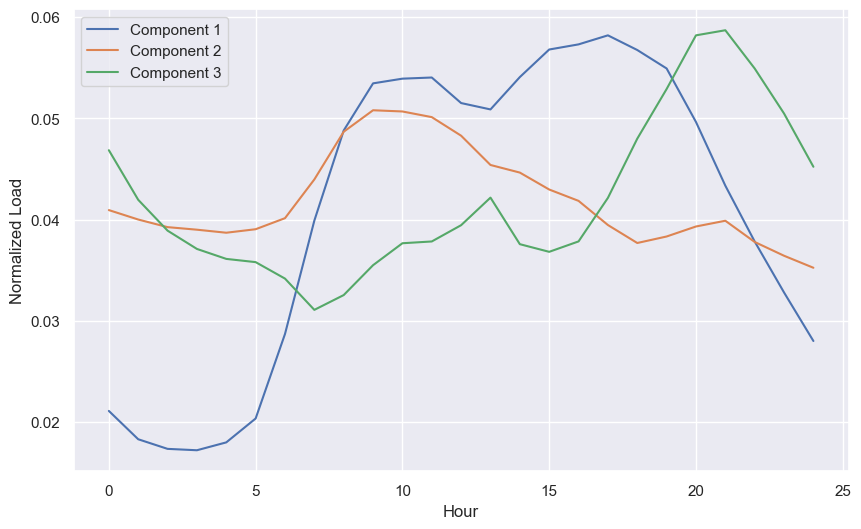

In [53]:
plot_components(H)

## Create concentration zone-level GeoDataFrame

In [54]:
W.zone.unique()

array(['Calabria', 'Centre-North', 'Centre-South', 'North', 'Sardinia',
       'Sicily', 'South'], dtype=object)

In [70]:
# Compute mean concentration per zone
W_zone = W[W.daytype == 'Working day'].groupby('zone')[[f'Component {k+1}' for k in range(n_components)]].mean()
W_zone

,Component 1,Component 2,Component 3
zone,,,
Calabria,0.386168,0.252675,0.357986
Centre-North,0.466733,0.392224,0.136709
Centre-South,0.444101,0.239893,0.312689
North,0.444143,0.445318,0.105304
Sardinia,0.249647,0.432260,0.311838
Sicily,0.311528,0.264048,0.420218
South,0.332778,0.306362,0.356251


In [71]:
W_gdf = W.merge(gdf, on='zone', how='left')

In [72]:
W_zone_gdf = gdf.merge(W_zone, left_index=True, right_index=True)

## Choropleth map

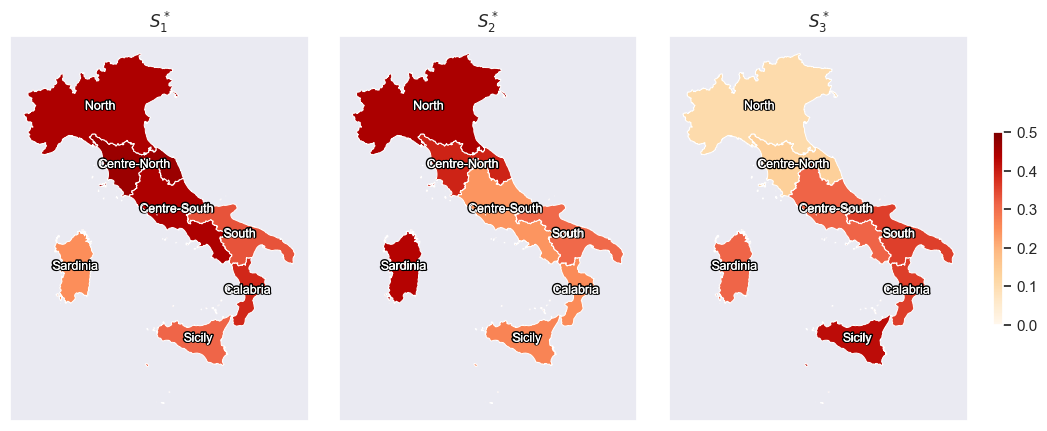

In [73]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

plt.subplots_adjust(wspace=-0.35)

for k in range(n_components):
    component = f'Component {k+1}'
    plot_zone_concentrations(W_zone_gdf, component, cmap='OrRd', legend=(k == n_components-1)*True, vmin=0, vmax=0.5, linewidth=0.7, title=f"$S_{k+1}^*$", ax=axs[k], legend_kwds={'shrink': 0.5})


# Ternary plot

In [74]:
W_zone.mean()

Component 1    0.376443
Component 2    0.333254
Component 3    0.285856
dtype: float64

In [75]:
W_conc = W[[f'Component {k+1}' for k in range(n_components)]]

In [76]:
W_conc

,Component 1,Component 2,Component 3
Calabria_2021-01-01_Holiday,0.243700,1.889848e-07,0.756708
Calabria_2021-01-02_Saturday,0.384557,7.108273e-02,0.540414
Calabria_2021-01-03_Holiday,0.472593,3.588847e-04,0.526397
Calabria_2021-01-04_Monday,0.619676,7.779828e-02,0.303967
Calabria_2021-01-05_Working day,0.431341,3.286309e-01,0.235553
...,...,...,...
South_2022-12-27_Working day,0.644732,1.467917e-02,0.337700
South_2022-12-28_Working day,0.801023,8.385690e-22,0.213084
South_2022-12-29_Working day,0.407560,2.943760e-01,0.294334
South_2022-12-30_Working day,0.555985,4.103093e-06,0.453270


## Scatter plot per region

In [77]:
fig = px.scatter_ternary(W, a="Component 1", b="Component 2", c="Component 3", color='zone')

fig.update_traces(marker=dict(size=4),
                  selector=dict(mode='markers'))

# fig.update_layout(width=500, height=500)

## Per daytype

In [85]:
fig = px.scatter_ternary(W[W.zone=='North'], a="Component 1", b="Component 2", c="Component 3", color='daytype')

fig.update_traces(marker=dict(size=4),
                  selector=dict(mode='markers'))

# fig.update_layout(width=500, height=500)

In [79]:
W

,Component 1,Component 2,Component 3,zone,year,month,daytype
Calabria_2021-01-01_Holiday,0.243700,1.889848e-07,0.756708,Calabria,2021,01,Holiday
Calabria_2021-01-02_Saturday,0.384557,7.108273e-02,0.540414,Calabria,2021,01,Saturday
Calabria_2021-01-03_Holiday,0.472593,3.588847e-04,0.526397,Calabria,2021,01,Holiday
Calabria_2021-01-04_Monday,0.619676,7.779828e-02,0.303967,Calabria,2021,01,Monday
Calabria_2021-01-05_Working day,0.431341,3.286309e-01,0.235553,Calabria,2021,01,Working day
...,...,...,...,...,...,...,...
South_2022-12-27_Working day,0.644732,1.467917e-02,0.337700,South,2022,12,Working day
South_2022-12-28_Working day,0.801023,8.385690e-22,0.213084,South,2022,12,Working day
South_2022-12-29_Working day,0.407560,2.943760e-01,0.294334,South,2022,12,Working day
South_2022-12-30_Working day,0.555985,4.103093e-06,0.453270,South,2022,12,Working day


In [80]:
W

,Component 1,Component 2,Component 3,zone,year,month,daytype
Calabria_2021-01-01_Holiday,0.243700,1.889848e-07,0.756708,Calabria,2021,01,Holiday
Calabria_2021-01-02_Saturday,0.384557,7.108273e-02,0.540414,Calabria,2021,01,Saturday
Calabria_2021-01-03_Holiday,0.472593,3.588847e-04,0.526397,Calabria,2021,01,Holiday
Calabria_2021-01-04_Monday,0.619676,7.779828e-02,0.303967,Calabria,2021,01,Monday
Calabria_2021-01-05_Working day,0.431341,3.286309e-01,0.235553,Calabria,2021,01,Working day
...,...,...,...,...,...,...,...
South_2022-12-27_Working day,0.644732,1.467917e-02,0.337700,South,2022,12,Working day
South_2022-12-28_Working day,0.801023,8.385690e-22,0.213084,South,2022,12,Working day
South_2022-12-29_Working day,0.407560,2.943760e-01,0.294334,South,2022,12,Working day
South_2022-12-30_Working day,0.555985,4.103093e-06,0.453270,South,2022,12,Working day


In [81]:
zones = [
    'North',
    'Centre-North',
    'Centre-South',
    'South',
    'Sardinia',
    'Sicily',
    #'Calabria',
]

In [82]:
daytypes = ['Monday', 'Working day', 'Saturday', 'Holiday']

In [83]:
colors_plasma = [plasma(value) for value in np.linspace(0, 0.9, len(daytypes))]

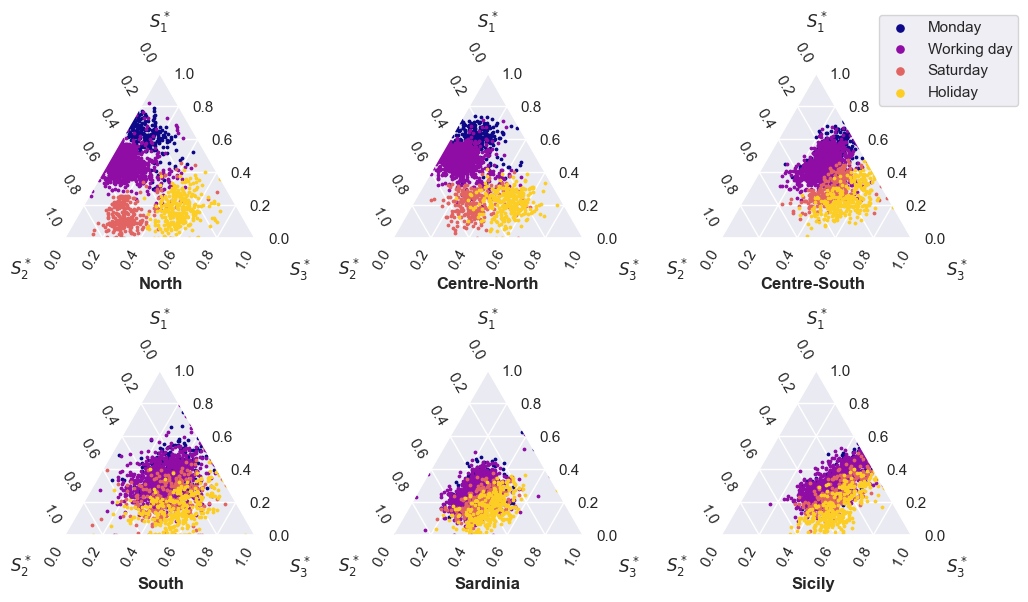

In [84]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6), subplot_kw={'projection': 'ternary'}, sharex=True, sharey=True)

plt.subplots_adjust(hspace=0.8)

for k, zone in enumerate(zones):
    i = k // 3
    j = k % 3
    ax = axs[i, j]
    W_zone = W[W.zone==zone]
    for idx, dt in enumerate(daytypes):
        W_dt = W_zone[W_zone.daytype == dt]
        ax.scatter(W_dt['Component 1'], W_dt['Component 2'], W_dt['Component 3'], s=3, label=dt, color=colors_plasma[idx])
    # if i == 0:
        axs[i,j].set_tlabel('$S_1^*$')
    # if j == 0:
        axs[i,j].set_llabel('$S_2^*$')
        axs[i,j].laxis.set_label_rotation_mode('horizontal')
    # if j == 2:
        axs[i,j].set_rlabel('$S_3^*$')
        axs[i,j].raxis.set_label_rotation_mode('horizontal')

# Add titles under each subplot
for i, zone in enumerate(zones[:3]):
    fig.text(0.24 + i * 0.815 / len(zones[:3]), 0.52, zone, ha='center', fontdict={'fontweight': 'bold'})
for i, zone in enumerate(zones[3:]):
    fig.text(0.24 + i * 0.815 / len(zones[3:]), 0.02, zone, ha='center', fontdict={'fontweight': 'bold'})

axs[0,2].legend(markerscale=3, bbox_to_anchor=(1.6, 1.4), loc='upper right')


In [86]:
zones

['North', 'Centre-North', 'Centre-South', 'South', 'Sardinia', 'Sicily']

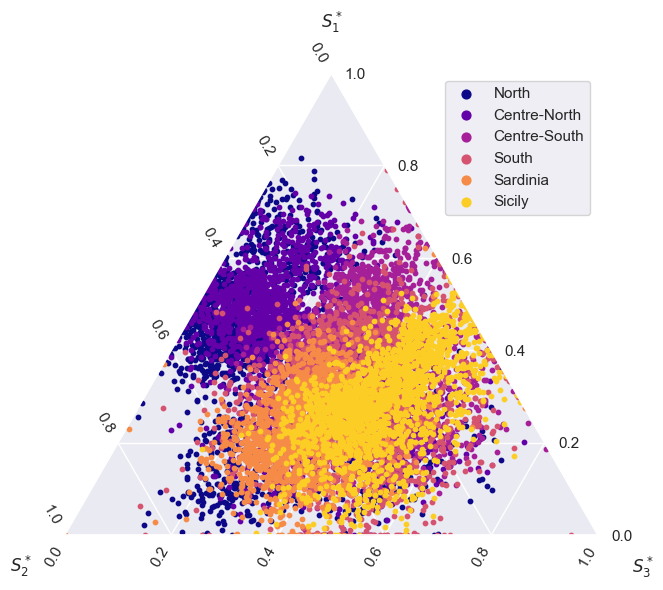

In [87]:
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': 'ternary'}, sharex=True, sharey=True)
colors_plasma = [plasma(value) for value in np.linspace(0, 0.9, len(zones))]

for idx, zone in enumerate(zones):
    W_zone = W[W.zone == zone]
    ax.scatter(W_zone['Component 1'], W_zone['Component 2'], W_zone['Component 3'], s=10, label=zone, color=colors_plasma[idx])
# if i == 0:
    ax.set_tlabel('$S_1^*$')
# if j == 0:
    ax.set_llabel('$S_2^*$')
    ax.laxis.set_label_rotation_mode('horizontal')
# if j == 2:
    ax.set_rlabel('$S_3^*$')
    ax.raxis.set_label_rotation_mode('horizontal')


ax.legend(markerscale=2, loc='upper right')


In [88]:
W_zone_month = W.groupby(['zone', 'month', 'daytype'], as_index=False)[[f'Component {k+1}' for k in range(n_components)]].mean()
W_zone_month['month'] = W_zone_month.month.astype(int)
W_zone_month

,zone,month,daytype,Component 1,Component 2,Component 3
0,Calabria,1,Holiday,0.370091,0.080099,0.549305
1,Calabria,1,Monday,0.581622,0.123027,0.296314
2,Calabria,1,Saturday,0.344850,0.206711,0.446146
3,Calabria,1,Working day,0.501508,0.242882,0.253829
4,Calabria,2,Holiday,0.307198,0.065098,0.629275
...,...,...,...,...,...,...
331,South,11,Working day,0.399390,0.225068,0.370736
332,South,12,Holiday,0.276478,0.157221,0.562186
333,South,12,Monday,0.492902,0.146728,0.356805
334,South,12,Saturday,0.358623,0.239218,0.398303


In [96]:
colors_twilight = [twilight_shifted(value) for value in np.linspace(0, 1, 12)]

In [90]:
W

,Component 1,Component 2,Component 3,zone,year,month,daytype
Calabria_2021-01-01_Holiday,0.243700,1.889848e-07,0.756708,Calabria,2021,01,Holiday
Calabria_2021-01-02_Saturday,0.384557,7.108273e-02,0.540414,Calabria,2021,01,Saturday
Calabria_2021-01-03_Holiday,0.472593,3.588847e-04,0.526397,Calabria,2021,01,Holiday
Calabria_2021-01-04_Monday,0.619676,7.779828e-02,0.303967,Calabria,2021,01,Monday
Calabria_2021-01-05_Working day,0.431341,3.286309e-01,0.235553,Calabria,2021,01,Working day
...,...,...,...,...,...,...,...
South_2022-12-27_Working day,0.644732,1.467917e-02,0.337700,South,2022,12,Working day
South_2022-12-28_Working day,0.801023,8.385690e-22,0.213084,South,2022,12,Working day
South_2022-12-29_Working day,0.407560,2.943760e-01,0.294334,South,2022,12,Working day
South_2022-12-30_Working day,0.555985,4.103093e-06,0.453270,South,2022,12,Working day


In [93]:
W['season'] = W.month.astype(int).map(month_to_season)
W

,Component 1,Component 2,Component 3,zone,year,month,daytype,season
Calabria_2021-01-01_Holiday,0.243700,1.889848e-07,0.756708,Calabria,2021,01,Holiday,Winter
Calabria_2021-01-02_Saturday,0.384557,7.108273e-02,0.540414,Calabria,2021,01,Saturday,Winter
Calabria_2021-01-03_Holiday,0.472593,3.588847e-04,0.526397,Calabria,2021,01,Holiday,Winter
Calabria_2021-01-04_Monday,0.619676,7.779828e-02,0.303967,Calabria,2021,01,Monday,Winter
Calabria_2021-01-05_Working day,0.431341,3.286309e-01,0.235553,Calabria,2021,01,Working day,Winter
...,...,...,...,...,...,...,...,...
South_2022-12-27_Working day,0.644732,1.467917e-02,0.337700,South,2022,12,Working day,Winter
South_2022-12-28_Working day,0.801023,8.385690e-22,0.213084,South,2022,12,Working day,Winter
South_2022-12-29_Working day,0.407560,2.943760e-01,0.294334,South,2022,12,Working day,Winter
South_2022-12-30_Working day,0.555985,4.103093e-06,0.453270,South,2022,12,Working day,Winter


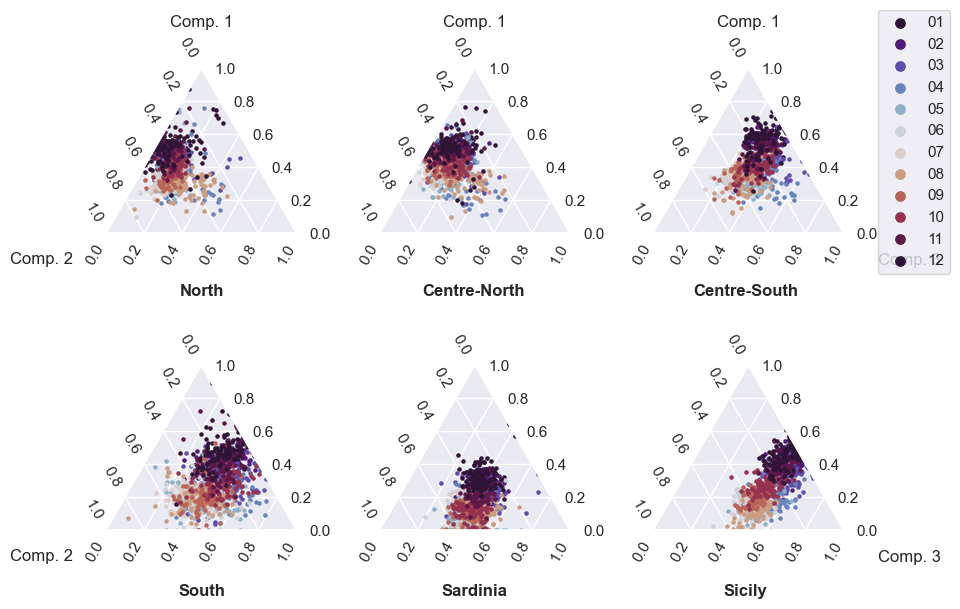

In [40]:
fig, axs = plt.subplots(2, 3, figsize=(10, 6), subplot_kw={'projection': 'ternary'}, sharex=True, sharey=True)

plt.subplots_adjust(hspace=0.8)

for k, zone in enumerate(zones):
    i = k // 3
    j = k % 3
    ax = axs[i, j]
    W_zone = W[(W.zone==zone)]
    for idx, month in enumerate(W.month.unique()):
        W_month = W_zone[W_zone.month == month]
        ax.scatter(W_month['Component 1'], W_month['Component 2'], W_month['Component 3'], s=5, label=month, color=colors_twilight[idx])

    if i == 0:
        axs[i,j].set_tlabel('Comp. 1')
    if j == 0:
        axs[i,j].set_llabel('Comp. 2')
        axs[i,j].laxis.set_label_rotation_mode('horizontal')
    if j == 2:
        axs[i,j].set_rlabel('Comp. 3')
        axs[i,j].raxis.set_label_rotation_mode('horizontal')

# Add titles under each subplot
for i, zone in enumerate(zones[:3]):
    fig.text(0.24 + i * 0.815 / len(zones[:3]), 0.5, zone, ha='center', fontdict={'fontweight': 'bold'})
for i, zone in enumerate(zones[3:]):
    fig.text(0.24 + i * 0.815 / len(zones[3:]), 0, zone, ha='center', fontdict={'fontweight': 'bold'})

axs[0,2].legend(markerscale=3, bbox_to_anchor=(1.6, 1.4), loc='upper right')

In [114]:
seasons = ['Winter', 'Summer']
# seasons = ['Spring', 'Fall']

In [110]:
colors_cool = [cool(value) for value in np.linspace(0, 1, len(seasons))]

In [115]:
colors = {
    'Summer': 'red',
    'Winter': 'blue'
}

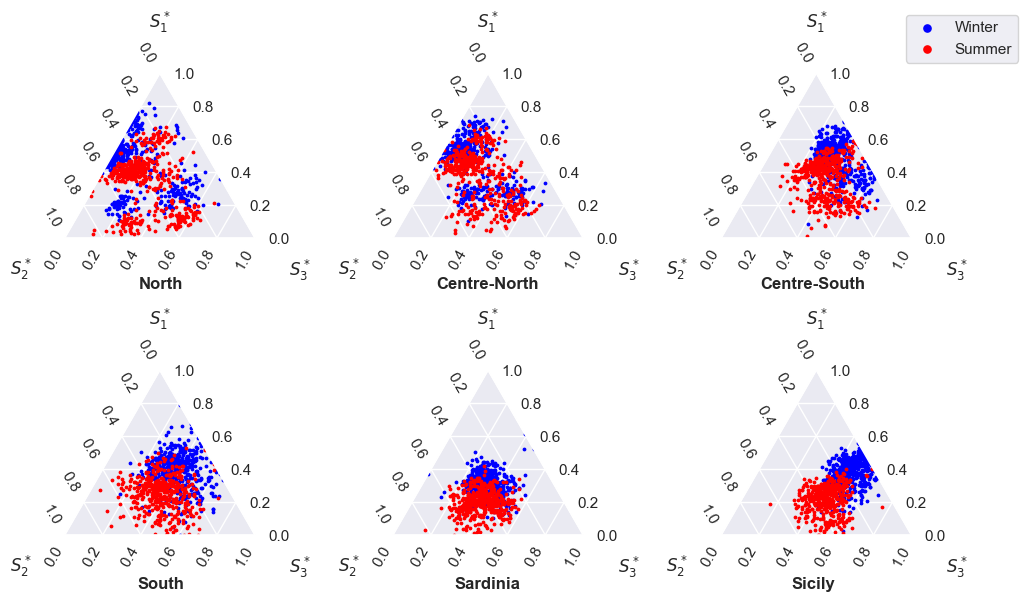

In [116]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6), subplot_kw={'projection': 'ternary'}, sharex=True, sharey=True)

plt.subplots_adjust(hspace=0.8)

for k, zone in enumerate(zones):
    i = k // 3
    j = k % 3
    ax = axs[i, j]
    W_zone = W[W.zone==zone]
    for idx, season in enumerate(seasons):
        W_season = W_zone[W_zone.season == season]
        ax.scatter(W_season['Component 1'], W_season['Component 2'], W_season['Component 3'], s=3, label=season, color=colors[season])
    # if i == 0:
        axs[i,j].set_tlabel('$S_1^*$')
    # if j == 0:
        axs[i,j].set_llabel('$S_2^*$')
        axs[i,j].laxis.set_label_rotation_mode('horizontal')
    # if j == 2:
        axs[i,j].set_rlabel('$S_3^*$')
        axs[i,j].raxis.set_label_rotation_mode('horizontal')

# Add titles under each subplot
for i, zone in enumerate(zones[:3]):
    fig.text(0.24 + i * 0.815 / len(zones[:3]), 0.52, zone, ha='center', fontdict={'fontweight': 'bold'})
for i, zone in enumerate(zones[3:]):
    fig.text(0.24 + i * 0.815 / len(zones[3:]), 0.02, zone, ha='center', fontdict={'fontweight': 'bold'})

axs[0,2].legend(markerscale=3, bbox_to_anchor=(1.6, 1.4), loc='upper right')

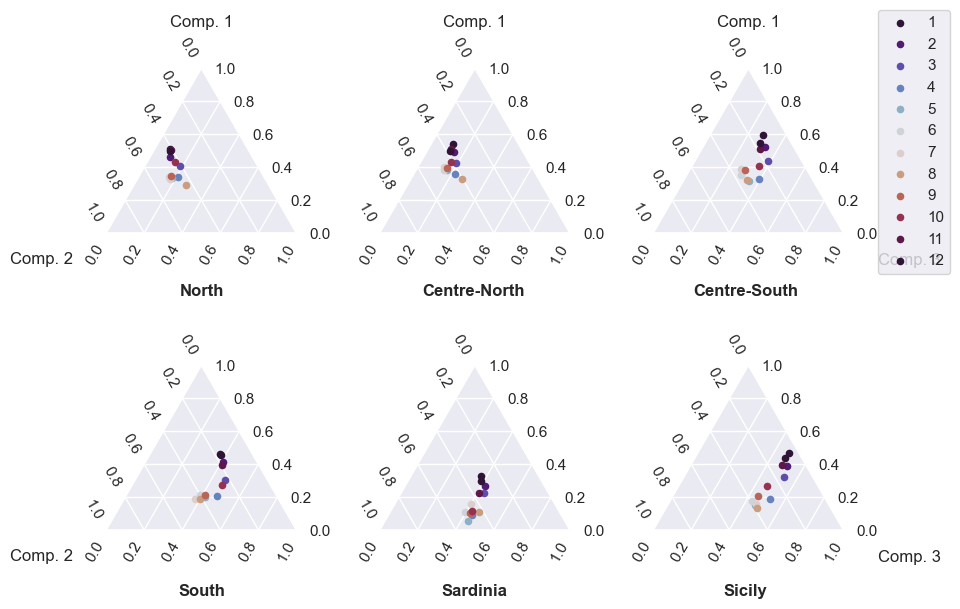

In [42]:
fig, axs = plt.subplots(2, 3, figsize=(10, 6), subplot_kw={'projection': 'ternary'}, sharex=True, sharey=True)

plt.subplots_adjust(hspace=0.8)

for k, zone in enumerate(zones):
    i = k // 3
    j = k % 3
    ax = axs[i, j]
    W_zone = W_zone_month[W_zone_month.zone==zone]
    for idx, dt in enumerate(daytypes):
        W_dt = W_zone[W_zone.daytype == dt]

        for idx, month in enumerate(W_dt.month.unique()):
            W_month = W_dt[W_dt.month == month]
            ax.scatter(W_month['Component 1'], W_month['Component 2'], W_month['Component 3'], s=20, label=month, color=colors_twilight[idx])

    if i == 0:
        axs[i,j].set_tlabel('Comp. 1')
    if j == 0:
        axs[i,j].set_llabel('Comp. 2')
        axs[i,j].laxis.set_label_rotation_mode('horizontal')
    if j == 2:
        axs[i,j].set_rlabel('Comp. 3')
        axs[i,j].raxis.set_label_rotation_mode('horizontal')

# Add titles under each subplot
for i, zone in enumerate(zones[:3]):
    fig.text(0.24 + i * 0.815 / len(zones[:3]), 0.5, zone, ha='center', fontdict={'fontweight': 'bold'})
for i, zone in enumerate(zones[3:]):
    fig.text(0.24 + i * 0.815 / len(zones[3:]), 0, zone, ha='center', fontdict={'fontweight': 'bold'})

axs[0,2].legend(markerscale=1, bbox_to_anchor=(1.6, 1.4), loc='upper right')

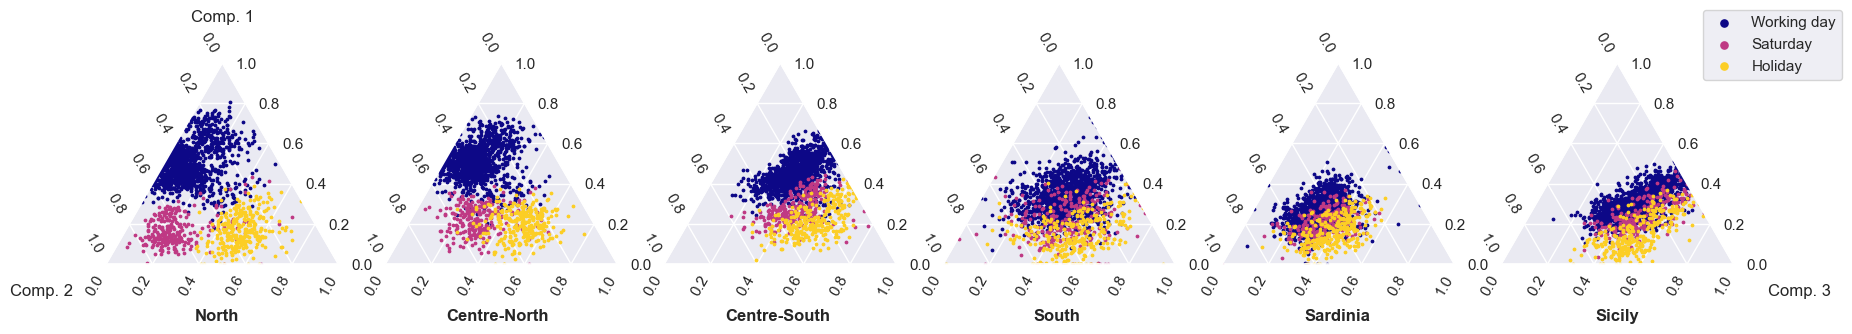

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(21, 7), subplot_kw={'projection': 'ternary'})

for k, zone in enumerate(zones):
    i = k // 3
    j = k % 3
    ax = axs[i, j]
    W_zone = W[W.zone==zone]
    for i, dt in enumerate(daytypes):
        W_dt = W_zone[W_zone.daytype == dt]
        ax.scatter(W_dt['Component 1'], W_dt['Component 2'], W_dt['Component 3'], s=3, label=dt, color=colors_plasma[i])
    axs[i,j].set_tlabel('Comp. 1')
    axs[i,j].set_llabel('Comp. 2')
    axs[i,j].laxis.set_label_rotation_mode('horizontal')
    axs[i,j].set_rlabel('Comp. 3')
    axs[i,j].raxis.set_label_rotation_mode('horizontal')

# Add titles under each subplot
for i, zone in enumerate(zones):
    fig.text(0.178 + i * 0.8 / len(zones), 0.27, zone, ha='center', fontdict={'fontweight': 'bold'})

axs[-1].legend(markerscale=3, bbox_to_anchor=(1.5, 1.3), loc='upper right')


In [101]:
print([0.2 + i*0.8 / len(zones) for i in range(len(zones))])

[0.2, 0.33333333333333337, 0.4666666666666667, 0.6000000000000001, 0.7333333333333334, 0.8666666666666667]


In [57]:
# Get the plasma colormap
cmap_plasma = plasma

# Define the number of colors you want to pick
num_colors = 3

# Generate evenly spaced values between 0 and 1
color_values = np.linspace(0, 1, num_colors)

# Get the corresponding colors from the colormap
colors_from_plasma = [cmap_plasma(value) for value in color_values]
colors_from_plasma

[(0.050383, 0.029803, 0.527975, 1.0),
 (0.798216, 0.280197, 0.469538, 1.0),
 (0.940015, 0.975158, 0.131326, 1.0)]

## Per month

In [191]:
fig = px.scatter_ternary(W, a="Component 1", b="Component 2", c="Component 3", color='month')

fig.update_traces(marker=dict(size=2),
                  selector=dict(mode='markers'))

# fig.update_layout(width=500, height=500)

In [169]:
colors[0]

(0.2980392156862745, 0.4470588235294118, 0.6901960784313725)